In [ ]:
%cd ../..


In [2]:
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision
from torchvision.io import ImageReadMode

from joblib import Parallel, delayed

import cv2

# Reconstruction
Reconstructs a mask from angle, width & distance data

#### Config

In [3]:
# folders should contain mean/ and std/ subfolders
angle_folder = "out/madw_angle/run_training"
distance_folder = "out/madw_dist/run_training_last"
width_folder = "out/madw_width/run_training_last"
mask_prior_folder = None # "out/madw_prior/run_test" # set to None if you don't want to include prior masks
out_folder = "out/madw/training"

RESIZE_FACTOR = 0.25
BINARIZE_OUTPUT = True
BINARIZATION_PERCENTILE = 75 # in %
MASK_PRIOR_THRESHOLD = 0.5
OVERWRITE = False # whether to overwrite existing priors

#### This must be the same as in ADW-Transform!

In [4]:
PADDING = 25
SMOOTH_ANGLE = 2.0 # None to disable
SMOOTH_WIDTH = 1.0 # None to disable
SMOOTH_MASK_ITERATIONS = 3

# the image size that the model will be working on (matters for distance prediction!)
TARGET_SIZE = (224,224) 
# leave at (400,400) if doing cropping
# use (224,224) if rescaling

NORM_ANGLE_MIN, NORM_ANGLE_DELTA = -3.15, 6.3
NORM_DISTANCE_MIN, NORM_DISTANCE_DELTA = 0, np.sqrt(2*(TARGET_SIZE[0] + 2*PADDING)**2) + 1
NORM_WIDTH_MIN, NORM_WIDTH_DELTA = 0, TARGET_SIZE[0] / 4 # this might cause some overflows if chosen too small

In [5]:
def nearest_neighbor_interpolation_2D(arr, target_size):
    current_size = arr.shape
    row_ratio, col_ratio = np.array(target_size)/np.array(current_size)

    row_idx = (np.ceil(range(1, 1 + int(current_size[0]*row_ratio))/row_ratio) - 1).astype(int)
    col_idx = (np.ceil(range(1, 1 + int(current_size[1]*col_ratio))/col_ratio) - 1).astype(int)

    return arr[:,row_idx][col_idx,:]

In [6]:
def cart2pol(x, y, m_alpha):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    if m_alpha - phi > (2*np.pi + phi) - m_alpha:
        phi = 2*np.pi + phi
    return(rho, phi)

In [7]:
def norm_to_true(angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std, 
                 angle_min, angle_delta, distance_min, distance_delta, width_min, width_delta):
    angle_mean = angle_mean * angle_delta + angle_min
    angle_std = angle_std * angle_delta

    distance_mean = distance_mean * distance_delta + distance_min
    distance_std = distance_std * distance_delta

    width_mean = width_mean * width_delta + width_min
    width_std = width_std * width_delta    

    return angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std

In [8]:
def load_sample(name):
    angle_mean = (torchvision.io.read_image(os.path.join(angle_folder, 'mean', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    angle_std = (torchvision.io.read_image(os.path.join(angle_folder, 'std', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    distance_mean = (torchvision.io.read_image(os.path.join(distance_folder, 'mean', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    distance_std = (torchvision.io.read_image(os.path.join(distance_folder, 'std', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    width_mean = (torchvision.io.read_image(os.path.join(width_folder, 'mean', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    width_std = (torchvision.io.read_image(os.path.join(width_folder, 'std', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()

    return norm_to_true(angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std, 
                        NORM_ANGLE_MIN, NORM_ANGLE_DELTA, NORM_DISTANCE_MIN, NORM_DISTANCE_DELTA, NORM_WIDTH_MIN, NORM_WIDTH_DELTA)

In [9]:
def visualize_sample(angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std):
    def print_info(name, data_mean, data_std):
        print(f"{name} Mean: min {data_mean.min()}, max {data_mean.max()}, mean {data_mean.mean()}")
        print(f"{name} Std: min {data_std.min()}, max {data_std.max()}, mean {data_std.mean()}")

    fig,axs = plt.subplots(2,3)
    for ax in axs.flat:
        ax.axis('off')

    axs[0,0].set_title("angle")
    axs[0,0].imshow(angle_mean)
    axs[1,0].imshow(angle_std)

    axs[0,1].set_title("distance")
    axs[0,1].imshow(distance_mean)
    axs[1,1].imshow(distance_std)

    axs[0,2].set_title("width")
    axs[0,2].imshow(width_mean)
    axs[1,2].imshow(width_std)

    print_info("Angle", angle_mean, angle_std)
    print_info("Distance", distance_mean, distance_std)
    print_info("Width", width_mean, width_std)

    plt.tight_layout()
    plt.show()

In [10]:
def clamp_outliers(data, perc):
    # perc from 0 - 100
    thresh_low = np.percentile(data, perc)
    thresh_high = np.percentile(data, 100 - perc)
    data[data < thresh_low] = thresh_low
    data[data > thresh_high] = thresh_high
    return data

In [1]:
def aggregate_votes(angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std, resize_factor = 0.25):
    original_size = angle_mean.shape[-1]
    # subsample
    size = round(resize_factor * original_size)

    res_total_influence = np.zeros((size,size))
    vote_width_mean = np.zeros((size,size))
    vote_width_std = np.zeros((size,size))

    angle_mean = nearest_neighbor_interpolation_2D(angle_mean, (size,size)) # invariant to scaling
    angle_std = nearest_neighbor_interpolation_2D(angle_std, (size,size))
    dist_mean = nearest_neighbor_interpolation_2D(dist_mean, (size,size)) * resize_factor # k * X ~ N(k * m, (k*s)^2)
    dist_std = nearest_neighbor_interpolation_2D(dist_std, (size,size)) * resize_factor
    width_mean = nearest_neighbor_interpolation_2D(width_mean, (size,size)) # keep original scale
    width_std = nearest_neighbor_interpolation_2D(width_std, (size,size))

    # precompute distances and angles
    indices_ext = np.array([range(-size+1, size)]).T @ np.ones((1,2*size-1))
    dists = np.sqrt(np.sum(np.stack([indices_ext**2, indices_ext.T**2], axis=-1), axis=-1))

    indices_2d = np.stack([indices_ext, indices_ext.T], axis=-1)
    angles = np.arctan2(indices_2d[:,:,0], indices_2d[:,:,1])

    res_total_influence = np.zeros((size,size))
    vote_width_mean = np.zeros((size,size))
    vote_width_var = np.ones((size,size))

    # precompute constants
    joint_norm_std = 1 / (2 * np.pi * angle_std * dist_std)

    for y in range(size):
        for x in range(size):
            # (y,x) are pixel u from the report
            # we do vectorization over all pixels t

            # the votes of pixel u
            local_angle_mean = angle_mean[y,x]
            local_angle_std = angle_std[y,x]
            local_dist_mean = dist_mean[y,x]
            local_dist_std = dist_std[y,x]
            local_width_mean = width_mean[y,x]
            local_width_var = width_std[y,x] * width_std[y,x]
            
            # load the precomputed angles and distances based on the coordinates of u
            local_dists = dists[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
            local_angles = angles[size-1-y:size-1-y+size,size-1-x:size-1-x+size]

            # compute the closest angle to the local angle (so it's always < 180°). This is important bc it always gives the maximum possible influence.
            closest_local_angles = local_angles + np.sign(local_angle_mean - local_angles) * (np.abs(local_angle_mean - local_angles) > np.pi) * 2 * np.pi

            # influence map (prob that u points to any other t), basically elementwise gaussian
            influence = joint_norm_std[y,x] * np.exp(-0.5 * (((closest_local_angles - local_angles) / local_angle_std)**2 + ((local_dists - local_dist_mean) / local_dist_std)**2))

            res_total_influence += influence
            vote_width_mean += influence * local_width_mean
            vote_width_var += influence * (local_width_var + local_width_mean**2) # work in var space, as then we can pull out the normalizing constant (total influence on any pixel t)

    # divide by normalizing constant (basically normalizing influence to sum to 1)
    vote_width_mean /= res_total_influence 
    vote_width_var /= res_total_influence 

    # finally subtract mean^2
    vote_width_var -= vote_width_mean**2 

    vote_width_std = np.sqrt(vote_width_var)
    return vote_width_mean, vote_width_std

In [12]:
def construct_mask(vote_width_mean, vote_width_std, resize_factor = 0.25, mask_prior = None, prior_threshold = 0.5):
    size = vote_width_mean.shape[-1]

    # rescale the aggregated votes (since we are subsampling)
    vote_width_mean *= resize_factor
    vote_width_std *= resize_factor 

    # precompute the distances
    indices_ext = np.array([range(-size+1, size)]).T @ np.ones((1,2*size-1))
    dists = np.sqrt(np.sum(np.stack([indices_ext**2, indices_ext.T**2], axis=-1), axis=-1))

    res_mask = np.zeros((size,size))

    for y in range(size):
        for x in range(size):
            # (y,x) is pixel t from report

            # ignore all votes with width close to 0 (=> speed up)
            if vote_width_mean[y,x] < 0.1: 
                continue

            # if you include a prior mask, only consider those pixels that are already masked
            if mask_prior is not None:
                if mask_prior[y,x] < prior_threshold:
                    continue
            
            norm = stats.norm(vote_width_mean[y,x], vote_width_std[y,x])
            local_dists = dists[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
            
            # compute chance that t points to any pixel s
            prop_that_road = 1.0 - norm.cdf(local_dists)

            # we additively construct the final mask
            res_mask = np.maximum(res_mask, prop_that_road)

    return res_mask

# Generate Data
Execute this code to run reconstruction with the specified masks. This process might take a while (took ~1h for 1k images)

In [13]:
def process(i,img_name):
    output_path = os.path.join(out_folder, img_name)
    if not OVERWRITE and os.path.exists(output_path):
        return
    
    angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std = load_sample(img_name)
    original_size = angle_mean.shape[-1]

    dist_std /= 10.0 # seems to work better with lower dist, could be tuned further

    vote_width_mean, vote_width_std = aggregate_votes(angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std, resize_factor=RESIZE_FACTOR)

    mask_prior = None
    if mask_prior_folder is not None:
        mask_prior = (torchvision.io.read_image(os.path.join(mask_prior_folder, img_name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
        
    res_mask = construct_mask(vote_width_mean, vote_width_std, resize_factor=RESIZE_FACTOR, mask_prior=mask_prior, prior_threshold=MASK_PRIOR_THRESHOLD)
    
    thresh_res_mask = res_mask
    if BINARIZE_OUTPUT:
        threshold = np.percentile(res_mask, BINARIZATION_PERCENTILE)
        thresh_res_mask = (res_mask > threshold) * 1.0

    output = nearest_neighbor_interpolation_2D(thresh_res_mask, (original_size,original_size))
    cv2.imwrite(output_path, output * 255)

In [15]:
os.makedirs(out_folder, exist_ok=True)
r = Parallel(n_jobs=8)(delayed(process)(i, img_name) for i,img_name in enumerate(os.listdir(os.path.join(angle_folder, 'mean'))))

# Manual
This section can be used to inspect the reconstruction of a single image

Angle Mean: min -2.1123528480529785, max 2.2111763954162598, mean -0.1256759613752365
Angle Std: min 0.06423529982566833, max 0.1976470649242401, mean 0.1321113109588623
Distance Mean: min 0.0, max 56.36979293823242, mean 25.123655319213867
Distance Std: min 3.96112060546875, max 4.722874641418457, mean 3.9627058506011963
Width Mean: min 1.5372549295425415, max 7.466667175292969, mean 3.5582573413848877
Width Std: min 5.709804058074951, max 7.466667175292969, mean 5.723213195800781


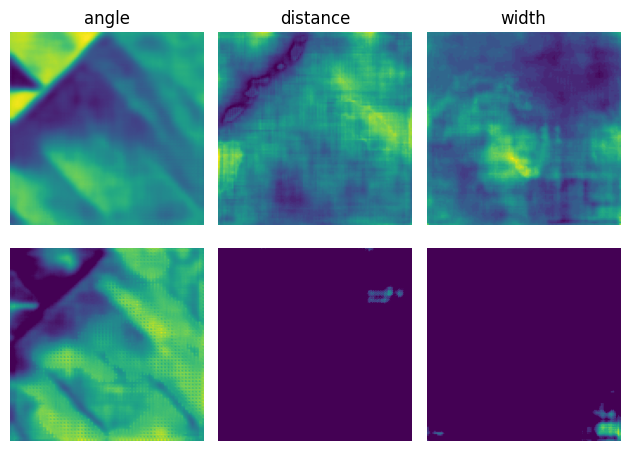

In [86]:
angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std = load_sample("satimage_144.png")
outlier_perc = 2.5
# angle_mean = clamp_outliers(angle_mean, outlier_perc)
# angle_std = clamp_outliers(angle_std, outlier_perc)
# dist_mean = clamp_outliers(dist_mean, outlier_perc)
# dist_std = clamp_outliers(dist_std, outlier_perc)
# width_mean = clamp_outliers(width_mean, outlier_perc)
# width_std = clamp_outliers(width_std, outlier_perc)

visualize_sample(angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std)